## 1.不同粒度模型剪枝实践




按照剪枝粒度进行划分，剪枝可分为细粒度剪枝（Fine-grained Pruning）、基于模式的剪枝（Pattern-based Pruning）、向量级剪枝（Vector-level Pruning）、内核级剪枝（Kernel-level Pruning）与通道级剪枝（Channel-level Pruning）。

如下图所示，展示了从细粒度剪枝到通道级的剪枝，剪枝越来越规则和结构化。

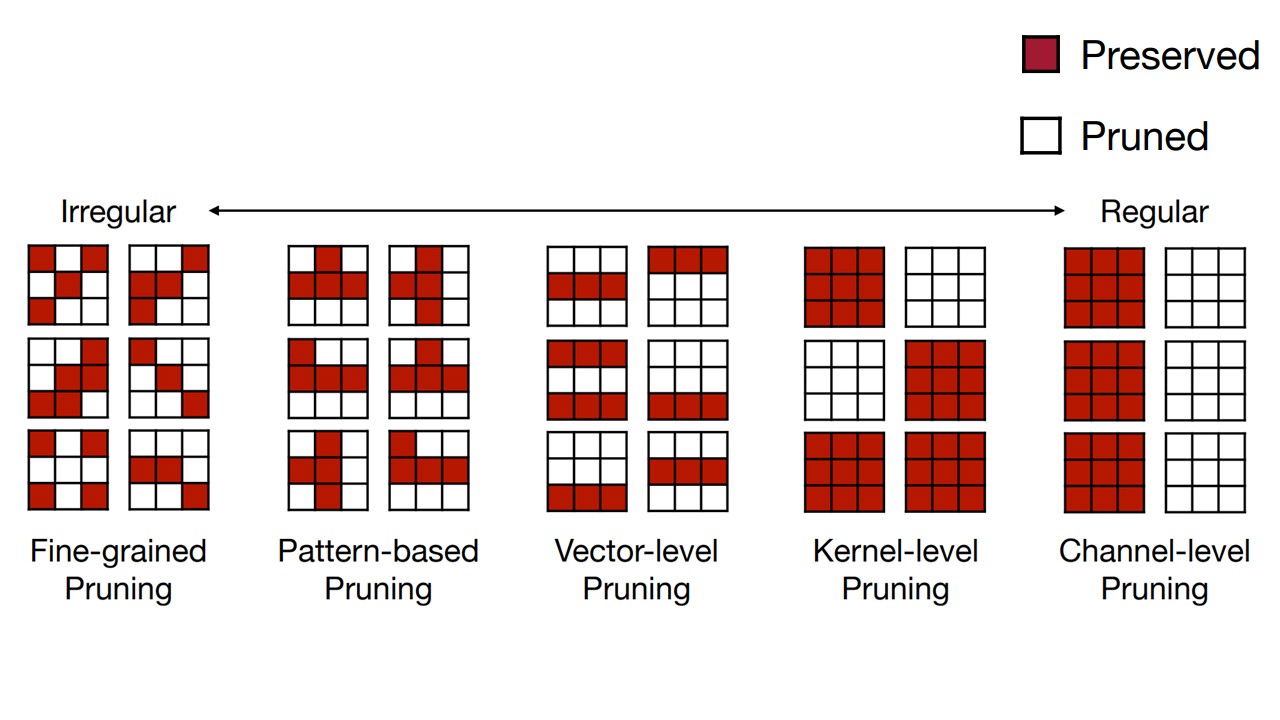

下面将分别用一些简单的例子来举例说明。

In [31]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文乱码

In [32]:
# 创建一个可视化2维矩阵函数，将值为0的元素与其他区分开
def plot_tensor(tensor, title):
    # 创建一个新的图像和轴
    fig, ax = plt.subplots()
    
    # 使用 CPU 上的数据，转换为 numpy 数组，并检查相等条件，设置颜色映射
    ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
    ax.set_title(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
    # 遍历矩阵中的每个元素并添加文本标签
    for i in range(tensor.shape[1]):
        for j in range(tensor.shape[0]):
            text = ax.text(j, i, f'{tensor[i, j].item():.2f}', ha="center", va="center", color="k")
    
    # 显示图像
    plt.show()


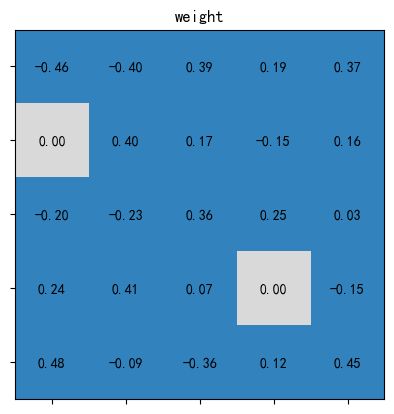

In [33]:
# 测试效果
weight=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                            [0.00, 0.40, 0.17, -0.15, 0.16],
                            [-0.20, -0.23, 0.36, 0.25, 0.03],
                            [0.24, 0.41, 0.07, 0.00, -0.15],
                            [0.48, -0.09, -0.36, 0.12, 0.45]])
plot_tensor(weight, 'weight')

## 细粒度剪枝

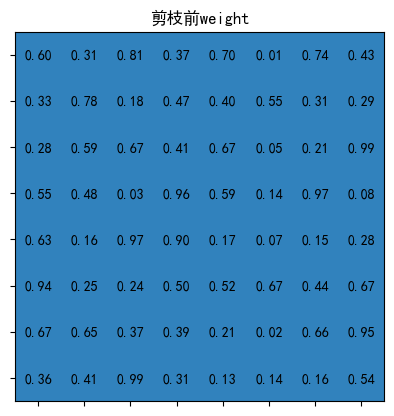

In [34]:
# 创建一个矩阵weight
weight = torch.rand(8, 8)
plot_tensor(weight, '剪枝前weight')

现在定义一个规则，比如想要将Tensor里的值小于0.5的都置为0

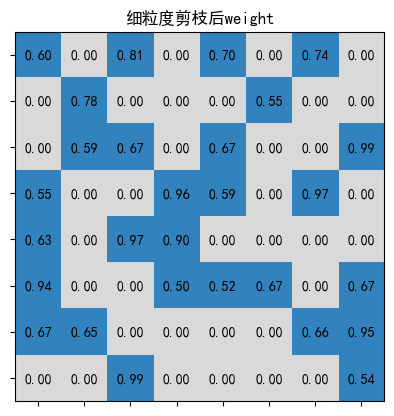

In [35]:
# 细粒度剪枝方法1
def _fine_grained_prune(tensor: torch.Tensor, threshold  : float) -> torch.Tensor:
    """
    :param tensor: 输入张量，包含需要剪枝的权重。
    :param threshold: 阈值，用于判断权重的大小。
    :return: 剪枝后的张量。
    """
    for i in range(tensor.shape[1]):
        for j in range(tensor.shape[0]):
            if tensor[i, j] < threshold:
                tensor[i][j] = 0
    return tensor

pruned_weight = _fine_grained_prune(weight, 0.5)
plot_tensor(weight, '细粒度剪枝后weight')

可能会有同学按照上述代码用for循环遍历去实现，虽然结果是对的，但如果参数太大的话，肯定会影响到速度，下面将介绍在剪枝中常用的一种方法，即使用mask掩码矩阵来实现。

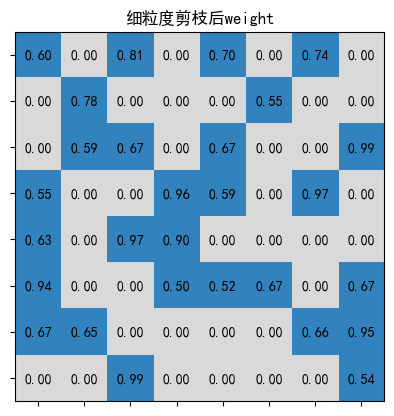

In [36]:
# 细粒度剪枝方法2
def fine_grained_prune(tensor: torch.Tensor, threshold  : float) -> torch.Tensor:
    """
    创建一个掩码张量，指示哪些权重不应被剪枝（应保持非零）。

    :param tensor: 输入张量，包含需要剪枝的权重。
    :param threshold: 阈值，用于判断权重的大小。
    :return: 剪枝后的张量。
    """
    mask = torch.gt(tensor, threshold)
    tensor.mul_(mask)
    return tensor
pruned_weight = fine_grained_prune(weight, 0.5)
plot_tensor(pruned_weight, '细粒度剪枝后weight')

## 基于模式的剪枝

这里以NVIDIA 4：2为例，创建一个patterns，如下图所示，由于是2:4，即从4个中取出2个置为0，可以算出一共有6种不同的模式；

然后将weight matrix变换成nx4的格式方便与pattern进行矩阵运算，运算后的结果为nx6的矩阵，在n的维度上进行argmax取得最大的索引(索引对应pattern)，然后将索引对应的pattern值填充到mask中。

![](<attachment:NVIDIA sparse.png>)
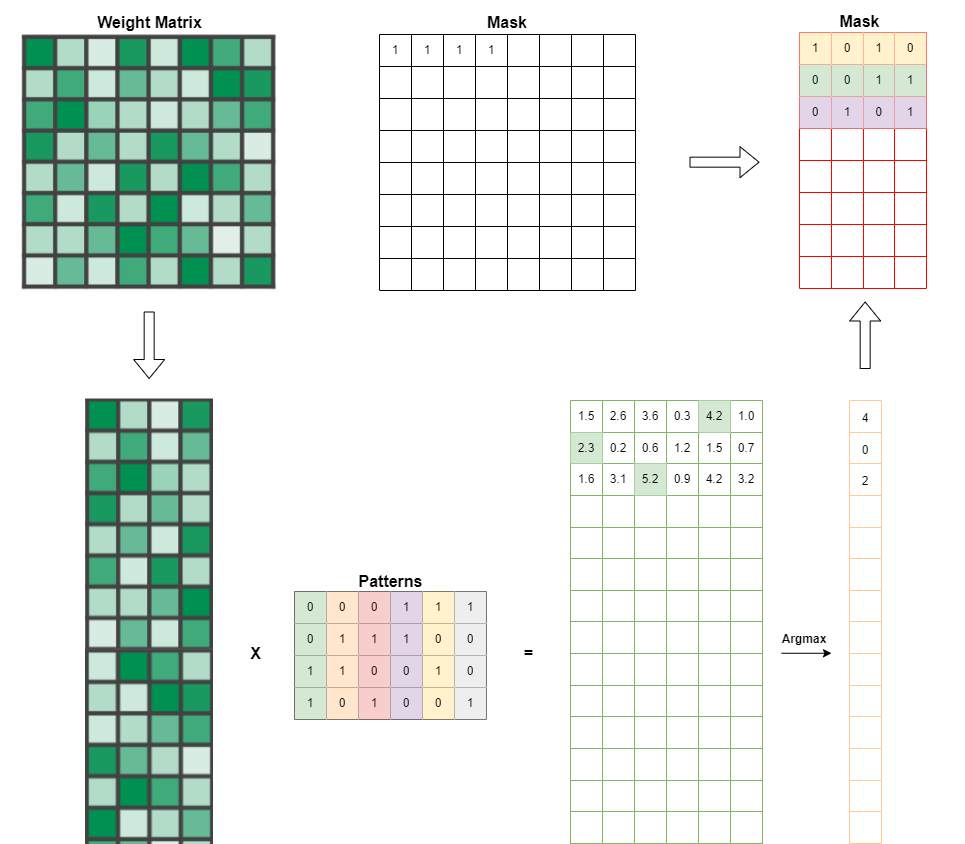

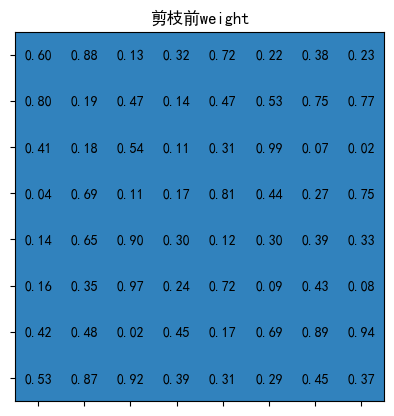

In [37]:
# 创建一个矩阵weight
weight = torch.rand(8, 8)
plot_tensor(weight, '剪枝前weight')

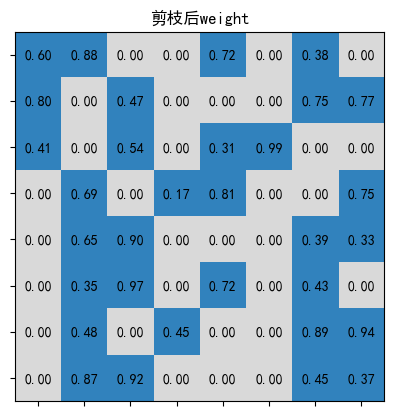

In [38]:
from itertools import permutations

def reshape_1d(tensor, m):
    # 转换成列为m的格式，若不能整除m则填充0
    if tensor.shape[1] % m > 0:
        mat = torch.FloatTensor(tensor.shape[0], tensor.shape[1] + (m - tensor.shape[1] % m)).fill_(0)
        mat[:, : tensor.shape[1]] = tensor
        return mat.view(-1, m)
    else:
        return tensor.view(-1, m)

def compute_valid_1d_patterns(m, n):
    patterns = torch.zeros(m)
    patterns[:n] = 1
    valid_patterns = torch.Tensor(list(set(permutations(patterns.tolist()))))
    return valid_patterns

def compute_mask(tensor, m, n):
    # 计算所有可能的模式
    patterns = compute_valid_1d_patterns(m,n)

    # 找到m:n最好的模式
    mask = torch.IntTensor(tensor.shape).fill_(1).view(-1,m)
    mat = reshape_1d(tensor, m)
    pmax = torch.argmax(torch.matmul(mat.abs(), patterns.t()), dim=1)
    mask[:] = patterns[pmax[:]]
    mask = mask.view(tensor.shape)
    return mask

def pattern_pruning(tensor, m, n):
    mask = compute_mask(weight, m, n)
    tensor.mul_(mask)
    return tensor

pruned_weight = pattern_pruning(weight, 4, 2)
plot_tensor(pruned_weight, '剪枝后weight')

## 向量级别剪枝

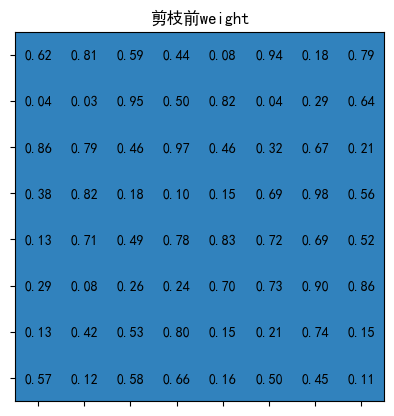

In [39]:
# 创建一个矩阵weight
weight = torch.rand(8, 8)
plot_tensor(weight, '剪枝前weight')

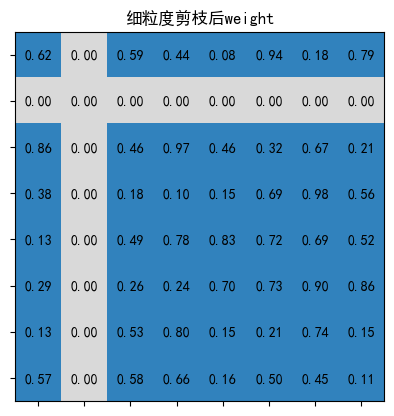

In [40]:
# 剪枝某个点所在的行与列
def vector_pruning(weight, point):
    row, col = point
    prune_weight = weight.clone()
    prune_weight[row, :] = 0
    prune_weight[:, col] = 0
    return prune_weight
point = (1, 1)
prune_weight = vector_pruning(weight, point)
plot_tensor(prune_weight, '细粒度剪枝后weight')

## 卷积核级别剪枝

In [41]:
# 定义可视化4维张量的函数
def visualize_tensor(tensor, title, batch_spacing=3):
    fig = plt.figure()  # 创建一个新的matplotlib图形
    ax = fig.add_subplot(111, projection='3d')  # 向图形中添加一个3D子图

    # 遍历张量的批次维度
    for batch in range(tensor.shape[0]):
        # 遍历张量的通道维度
        for channel in range(tensor.shape[1]):
            # 遍历张量的高度维度
            for i in range(tensor.shape[2]):
                # 遍历张量的宽度维度
                for j in range(tensor.shape[3]):
                    # 计算条形的x位置，考虑到不同批次间的间隔
                    x = j + (batch * (tensor.shape[3] + batch_spacing))
                    y = i  # 条形的y位置，即张量的高度维度
                    z = channel  # 条形的z位置，即张量的通道维度
                    # 如果张量在当前位置的值为0，则设置条形颜色为红色，否则为绿色
                    color = 'red' if tensor[batch, channel, i, j] == 0 else 'green'
                    # 绘制单个3D条形
                    ax.bar3d(x, y, z, 1, 1, 1, shade=True, color=color, edgecolor='black', alpha=0.9)

    ax.set_title(title)  # 设置3D图形的标题
    ax.set_xlabel('Width')  # 设置x轴标签，对应张量的宽度维度
    ax.set_ylabel('Height')  # 设置y轴标签，对应张量的高度维度
    ax.set_zlabel('Channel')  # 设置z轴标签，对于张量的通道维度
    ax.set_zlim(ax.get_zlim()[::-1])  # 反转z轴方向
    ax.zaxis.labelpad = 15  # 调整z轴标签的填充

    plt.show()  # 显示图形


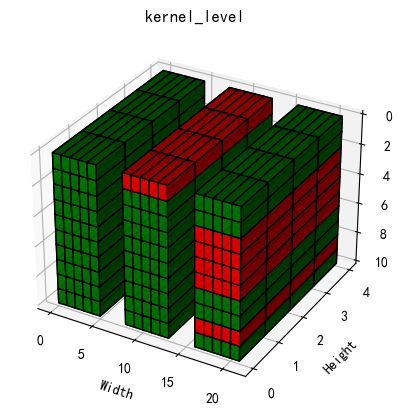

In [42]:
def prune_conv_layer(conv_layer, prune_method,title="", percentile=0.2, vis=True):
    prune_layer = conv_layer.clone()

    l2_norm = None
    mask = None

    # 计算每个kernel的L2范数
    l2_norm = torch.norm(prune_layer, p=2, dim=(-2, -1), keepdim=True)
    threshold = torch.quantile(l2_norm, percentile)
    mask = l2_norm > threshold
    prune_layer = prune_layer * mask.float()
    
    visualize_tensor(prune_layer,title=prune_method)  

# 使用PyTorch创建一个张量
tensor = torch.rand((3, 10, 4, 5))

# 调用函数进行剪枝

pruned_tensor = prune_conv_layer(tensor, 'kernel_level', vis=True)


## 通道级别剪枝

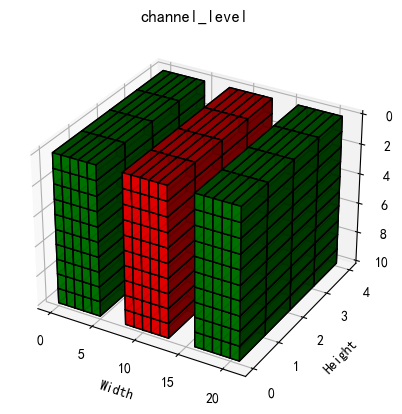

In [43]:
def prune_conv_layer(conv_layer, prune_method,title="", percentile=0.2, vis=True):
    prune_layer = conv_layer.clone()

    l2_norm = None
    mask = None

    # 计算每个kernel的L2范数
    l2_norm = torch.norm(prune_layer, p=2, dim=(1, 2, 3), keepdim=True)
    threshold = torch.quantile(l2_norm, percentile)
    mask = l2_norm > threshold
    prune_layer = prune_layer * mask.float()
    
    visualize_tensor(prune_layer,title=prune_method)  

# 使用PyTorch创建一个张量
tensor = torch.rand((3, 10, 4, 5))

# 调用函数进行剪枝

pruned_tensor = prune_conv_layer(tensor, 'channel_level', vis=True)

## 汇总
下面用3D的可视化方式对所有的剪枝方法对一个对比。

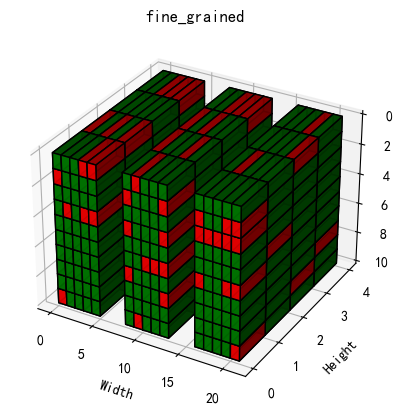

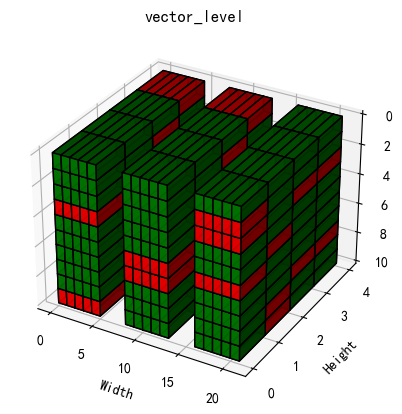

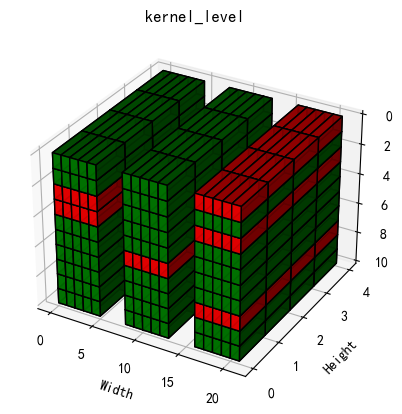

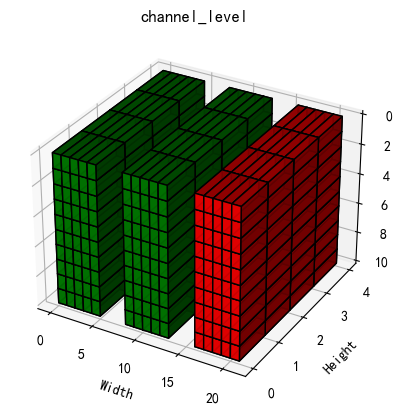

In [44]:
# 返回一个mask
def get_threshold_and_mask(norms, percentile):
    threshold = torch.quantile(norms, percentile)
    return norms > threshold

def prune_conv_layer(conv_layer, prune_method, title= "", percentile=0.2, vis=True):
    prune_layer = conv_layer.clone()
    mask = None
    if prune_method == "fine_grained":
        prune_layer[torch.abs(prune_layer) < percentile] = 0
    elif prune_method == "vector_level":
        mask = get_threshold_and_mask(torch.norm(prune_layer, p=2, dim=-1), percentile).unsqueeze(-1)
    elif prune_method == "kernel_level":
        mask = get_threshold_and_mask(torch.norm(prune_layer, p=2, dim=(-2, -1), keepdim=True), percentile)
    elif prune_method == "channel_level":
        mask = get_threshold_and_mask(torch.norm(prune_layer, p=2, dim=(1, 2, 3), keepdim=True), percentile)


    if mask is not None:
        prune_layer = prune_layer * mask.float()

    if vis:
        visualize_tensor(prune_layer, title=prune_method)  # 实现可视化的函数

    return prune_layer

# 使用PyTorch创建一个张量
tensor = torch.rand((3, 10, 4, 5)) 

# 调用函数进行剪枝
pruned_tensor = prune_conv_layer(tensor, 'fine_grained',  vis=True)
pruned_tensor = prune_conv_layer(tensor, 'vector_level', vis=True)
pruned_tensor = prune_conv_layer(tensor, 'kernel_level', vis=True)
pruned_tensor = prune_conv_layer(tensor, 'channel_level', vis=True)

